### <center> Домашнее задание к лекции 2

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Подготовка кода для ДЗ  

---

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [ ]:
#!pip install gensim

In [ ]:
#!pip install python-Levenshtein

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
#!pip install razdel

In [ ]:
#!pip install pymorphy2

In [10]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import nltk
import pymorphy2

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [15]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\Marat\AppData\Local\Temp\ipykernel_264\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 1min 20s
Wall time: 1min 45s


In [16]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 10min 40s
Wall time: 15min 16s


In [17]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [18]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [19]:
from gensim.models import LdaModel

In [20]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: total: 2min 29s
Wall time: 3min 8s


In [21]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [22]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.034348994),
 (6, 0.042942625),
 (8, 0.046715952),
 (13, 0.04840506),
 (14, 0.64925337),
 (18, 0.06972347),
 (19, 0.0544823),
 (20, 0.036061)]

In [23]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ракета завод северный высота сосед снятие км
topic_1: обращение офицер лечение мужчина формирование организм превысить
topic_2: товар двигатель катастрофа скорость разместить теория рейтинг
topic_3: статья автор nn изучение россия газета журналист
topic_4: препарат лаборатория доказательство расследование исследование автор лекарство
topic_5: ребёнок мозг закон пенсия семья женщина законопроект
topic_6: рейс билет аэропорт сочи тур аргумент санктпетербург
topic_7: турция турецкий бомба образовать русь грузовик горожанин
topic_8: nn пресссекретарить песок зарегистрировать мир искусство звезда
topic_9: площадь следователь ск убийство отдых праздник парка
topic_10: смерть иск конкурс супруг брат врач дональд
topic_11: новый всё рынок научный газета система строительство
topic_12: гражданин nn украинский украина ссср поверхность армия
topic_13: россия российский nn сша санкция путин украина
topic_14: погибнуть всё восток очень первый хороший место
topic_15: рост сша американский у

In [24]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [25]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.066710,...,0.0,0.000000,0.0,0.041738,0.000000,0.000000,0.0,0.86174,0.0,0.021904
1,4896,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.295591,...,0.0,0.579419,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000
2,4897,0.0,0.0,0.034352,0.0,0.0,0.0,0.043089,0.0,0.045646,...,0.0,0.000000,0.0,0.069879,0.054463,0.036135,0.0,0.00000,0.0,0.000000
3,4898,0.0,0.0,0.000000,0.0,0.0,0.0,0.018073,0.0,0.074708,...,0.0,0.000000,0.0,0.000000,0.181126,0.041373,0.0,0.00000,0.0,0.000000
4,4899,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.575745,0.0,0.000000,0.000000,0.000000,0.0,0.39714,0.0,0.000000


### Следующий шаг - векторные представления пользователей

In [26]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [27]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [28]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [29]:
get_user_embedding(user_articles_list)

array([0.        , 0.00257848, 0.        , 0.08841321, 0.        ,
       0.09652397, 0.        , 0.        , 0.01692227, 0.04997468,
       0.0206028 , 0.03440546, 0.04680874, 0.21570452, 0.        ,
       0.08119023, 0.04552944, 0.01054022, 0.        , 0.08053644,
       0.01966136, 0.        , 0.17522626, 0.        , 0.        ])

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.024236,0.000000,0.051476,0.000000,0.032092,0.004309,0.002867,0.104558,...,0.032071,0.038444,0.081931,0.0,0.024552,0.036717,0.039260,0.151616,0.000000,0.005731
1,u108690,0.0,0.007787,0.005672,0.048653,0.010951,0.070467,0.000000,0.000000,0.007787,...,0.054899,0.075337,0.015675,0.0,0.065282,0.027310,0.016128,0.214360,0.015811,0.000000
2,u108339,0.0,0.014672,0.003265,0.051891,0.030616,0.036020,0.000000,0.000000,0.004686,...,0.042082,0.085062,0.010769,0.0,0.110065,0.024104,0.021289,0.271425,0.008039,0.005276


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.024236,0.000000,0.051476,0.000000,0.032092,0.004309,0.002867,0.104558,...,0.038444,0.081931,0.0,0.024552,0.036717,0.039260,0.151616,0.000000,0.005731,0
1,u108690,0.0,0.007787,0.005672,0.048653,0.010951,0.070467,0.000000,0.000000,0.007787,...,0.075337,0.015675,0.0,0.065282,0.027310,0.016128,0.214360,0.015811,0.000000,1
2,u108339,0.0,0.014672,0.003265,0.051891,0.030616,0.036020,0.000000,0.000000,0.004686,...,0.085062,0.010769,0.0,0.110065,0.024104,0.021289,0.271425,0.008039,0.005276,1


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1321363 , 0.10514547, 0.3883731 , 0.20574606, 0.11342637,
       0.15086083, 0.09858882, 0.09792702, 0.17698617, 0.16770222])

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.255228, F-Score=0.648, Precision=0.607, Recall=0.694


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1645  110]
 [  76  169]]


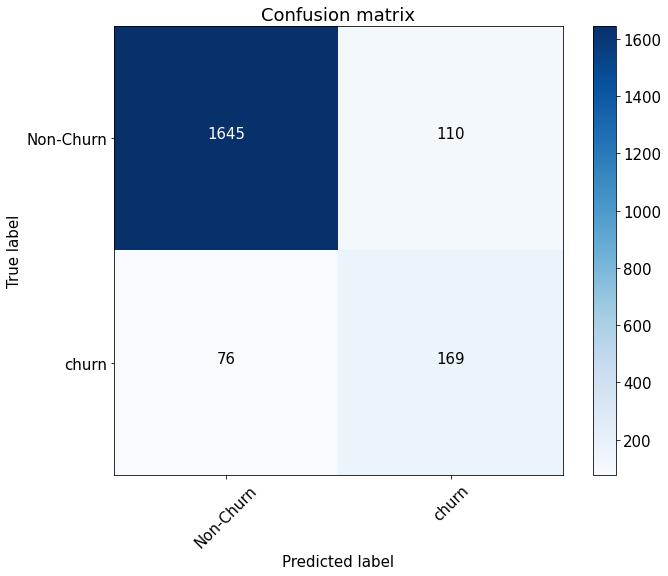

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
roc_auc_score(y_test, preds)

0.9317774289202863

#### **Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

---

In [42]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [43]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.01977943, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01079672, 0.21976647, 0.        ,
       0.0109389 , 0.        , 0.        , 0.        , 0.02534292,
       0.        , 0.        , 0.17841937, 0.        , 0.        ])

In [46]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.039807,0.00000,0.005500,0.0,0.0,0.044783,...,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.034420,0.163503,0.0,0.0
1,u108690,0.0,0.000000,0.0,0.041654,0.00000,0.058005,0.0,0.0,0.000000,...,0.051402,0.042142,0.0,0.0,0.060763,0.00000,0.015291,0.229217,0.0,0.0
2,u108339,0.0,0.010906,0.0,0.051478,0.02618,0.012644,0.0,0.0,0.000000,...,0.019306,0.099079,0.0,0.0,0.122027,0.01563,0.000000,0.289415,0.0,0.0


In [47]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.0,0.039807,0.00000,0.005500,0.0,0.0,0.044783,...,0.000000,0.0,0.0,0.000000,0.00000,0.034420,0.163503,0.0,0.0,0
1,u108690,0.0,0.000000,0.0,0.041654,0.00000,0.058005,0.0,0.0,0.000000,...,0.042142,0.0,0.0,0.060763,0.00000,0.015291,0.229217,0.0,0.0,1
2,u108339,0.0,0.010906,0.0,0.051478,0.02618,0.012644,0.0,0.0,0.000000,...,0.099079,0.0,0.0,0.122027,0.01563,0.000000,0.289415,0.0,0.0,1


In [48]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [49]:
logreg1 = LogisticRegression()
#обучим 
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [50]:
#наши прогнозы для тестовой выборки
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.15132308, 0.11179068, 0.57096122, 0.21408499, 0.11319672,
       0.06349884, 0.12500949, 0.10587383, 0.07156497, 0.10716562])

Перед расчетом метрик подготовим базу для таблицы сравнения метрик:

In [51]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.2552278410561649],
 [0.6476190476190475],
 [0.6071428571428571],
 [0.6938775510204082]]

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.287021, F-Score=0.783, Precision=0.745, Recall=0.824


In [53]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2552278410561649, 0.2870214035484439],
 [0.6476190476190475, 0.7829457364341086],
 [0.6071428571428571, 0.7453874538745388],
 [0.6938775510204082, 0.8244897959183674]]

Confusion matrix, without normalization
[[1686   69]
 [  44  201]]


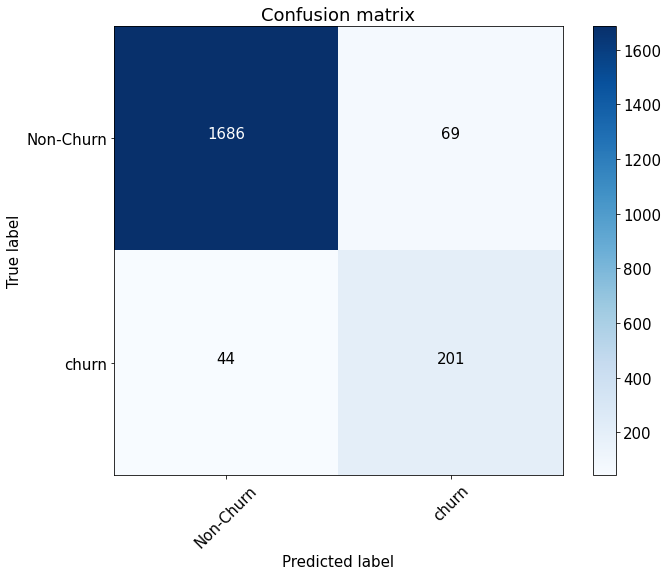

In [54]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
roc_auc_score(y_test1, preds1)

0.973179836036979

**Повторим п.2, но используя уже не медиану, а max**  

---

In [56]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [57]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.01547087, 0.        , 0.33924282, 0.        ,
       0.34739941, 0.        , 0.        , 0.10153361, 0.28578654,
       0.12361681, 0.20643274, 0.21634476, 0.41325429, 0.        ,
       0.26401561, 0.18671827, 0.06324133, 0.        , 0.296287  ,
       0.10548675, 0.        , 0.28999999, 0.        , 0.        ])

In [58]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.130152,0.000000,0.126926,0.000000,0.153549,0.025854,0.017199,0.434536,...,0.192429,0.185456,0.336954,0.0,0.147314,0.172512,0.116811,0.297208,0.000000,0.034384
1,u108690,0.0,0.029626,0.034033,0.145581,0.049314,0.172288,0.000000,0.000000,0.046724,...,0.108916,0.199795,0.048118,0.0,0.109916,0.108569,0.033262,0.360127,0.094869,0.000000
2,u108339,0.0,0.034843,0.019588,0.116347,0.055762,0.107274,0.000000,0.000000,0.028113,...,0.159597,0.154071,0.047946,0.0,0.177514,0.069309,0.127733,0.356552,0.032401,0.031658


In [59]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.130152,0.000000,0.126926,0.000000,0.153549,0.025854,0.017199,0.434536,...,0.185456,0.336954,0.0,0.147314,0.172512,0.116811,0.297208,0.000000,0.034384,0
1,u108690,0.0,0.029626,0.034033,0.145581,0.049314,0.172288,0.000000,0.000000,0.046724,...,0.199795,0.048118,0.0,0.109916,0.108569,0.033262,0.360127,0.094869,0.000000,1
2,u108339,0.0,0.034843,0.019588,0.116347,0.055762,0.107274,0.000000,0.000000,0.028113,...,0.154071,0.047946,0.0,0.177514,0.069309,0.127733,0.356552,0.032401,0.031658,1


In [60]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [61]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [62]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.033082  , 0.00374812, 0.84883016, 0.05753548, 0.0551976 ,
       0.09617558, 0.09967238, 0.01864262, 0.04682017, 0.25761771])

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.401728, F-Score=0.797, Precision=0.866, Recall=0.739


In [64]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2552278410561649, 0.2870214035484439, 0.4017276386288711],
 [0.6476190476190475, 0.7829457364341086, 0.7973568281938326],
 [0.6071428571428571, 0.7453874538745388, 0.8660287081339713],
 [0.6938775510204082, 0.8244897959183674, 0.7387755102040816]]

Confusion matrix, without normalization
[[1727   28]
 [  65  180]]


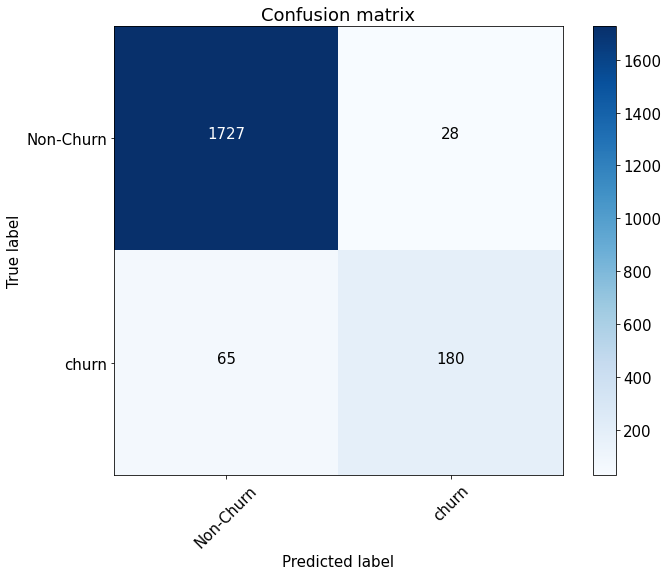

In [65]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [66]:
roc_auc_score(y_test2, preds2)

0.9736566079423221

**Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**  

---

In [67]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds1),roc_auc_score(y_test2, preds2)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

C:\Users\Marat\AppData\Local\Temp\ipykernel_264\2455461042.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df=pd.DataFrame(


,mean,median,max
Treshhold,0.255228,0.287021,0.401728
F-score,0.647619,0.782946,0.797357
Precision,0.607143,0.745387,0.866029
Recall,0.693878,0.824490,0.738776
ROC-AUC,0.931777,0.973180,0.973657


Как видно из таблицы, наиболее эффективным оказался метод с использованием медианы для получения эмбеддинга пользователя, т.к. мы получаем более разреженный вектор заинтересованности пользователя, вследствии того, что в отличии от среднего и максимального значения, медиана чаще будет равна нулю, на тех темах статей, которые редко появляются в векторе статей читаемых пользователем. То есть интересы пользователя будут выражены наиболее явно.